## 文本导入

In [13]:
import csv
import numpy as np
import pandas as pd

weibo_topic_aug = pd.read_csv('./Data/WeiboTopic_20210805_23-35.csv')
weibo_topic_sept = pd.read_csv('./Data/WeiboTopic_20210906_23-12.csv')

content_aug = weibo_topic_aug['内容']
content_sept = weibo_topic_sept['内容']


## 腾讯云NLP 情感分析

In [14]:
secretId = "your Id"
secretKey = "your Key"

import json
from tencentcloud.common import credential
from tencentcloud.common.profile.client_profile import ClientProfile
from tencentcloud.common.profile.http_profile import HttpProfile
from tencentcloud.common.exception.tencent_cloud_sdk_exception import TencentCloudSDKException
from tencentcloud.nlp.v20190408 import nlp_client, models

def sentiment_analyze(contents):
    sentiment, positive_score, negative_score = [], [], []
    try: 
        cred = credential.Credential(secretId, secretKey) 
        httpProfile = HttpProfile()
        httpProfile.endpoint = "nlp.tencentcloudapi.com"

        clientProfile = ClientProfile()
        clientProfile.httpProfile = httpProfile
        client = nlp_client.NlpClient(cred, "ap-guangzhou", clientProfile)

        req = models.SentimentAnalysisRequest()
        for content in contents:
            content = str(content)
            params = {
                # 待分析的文本（仅支持UTF-8格式，不超过200字）
                "Text": content[:100],
                # 待分析文本所属的类型，仅当输入参数Mode取值为2class时有效（默认取4值）： 1、商品评论类 2、社交类 3、美食酒店类 4、通用领域类
                "Flag": 4, 
                # 情感分类模式选项，可取2class或3class（默认值为2class） 1、2class：返回正负面二分类情感结果 2、3class：返回正负面及中性三分类情感结果            #
                "Mode": "2class"
            }
            req.from_json_string(json.dumps(params))

            resp = client.SentimentAnalysis(req) 
            # print(resp.to_json_string()) 
            sentiment.append(resp.Sentiment)
            positive_score.append(resp.Positive)
            # neutral_score.append(resp.Neutral)
            negative_score.append(resp.Negative)

        return sentiment, positive_score, negative_score

    except TencentCloudSDKException as err: 
        print(err) 


In [15]:
sentiment_aug = sentiment_analyze(content_aug)
sentiment_sept = sentiment_analyze(content_sept)

## 情感偏向条目计数

In [16]:
import collections
print('August Data : ' + str(collections.Counter(sentiment_aug[0])))
print('September Data : ' + str(collections.Counter(sentiment_sept[0])))

August Data : Counter({'positive': 164, 'negative': 83})
September Data : Counter({'positive': 207, 'negative': 85})


In [17]:
sentiment = sentiment_aug[0] + sentiment_sept[0]
contents = pd.concat((content_aug, content_sept), ignore_index=True)
all_contents = [str(content) for content in contents]
positive_contents = [contents[i]
                    for i in range(len(contents)) if sentiment[i] == 'positive']
# neutral_contents = [contents[i]
                    # for i in range(len(contents)) if sentiment[i] == 'neutral']
negative_contents = [contents[i]
                     for i in range(len(contents)) if sentiment[i] == 'negative']

print(len(positive_contents))
print(len(negative_contents))


371
168


## 百度LAC分词

In [18]:
from LAC import LAC
import re

lac = LAC(mode='lac')

zhPattern = re.compile('[\u4e00-\u9fa5]+')

def content_seg(content_list):
    res = []
    for i in range(len(content_list)):
        segments = []
        segs, atrs = lac.run(content_list[i])
        for i in range(len(segs)):
            if zhPattern.search(segs[i]) and atrs[i] in ['n', 'nz', 'a', 'PER', 'LOC', 'ORG', 'v', 'ad', 'vd', 'an', 'vn', 's', 'nw']:
                segments.append(segs[i])
        res.append(' '.join(segments))
    return res


In [19]:
contents = content_seg(all_contents)
len(contents)

/Users/fellno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


539

## LDA绘图函数和词云绘图函数

In [77]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family': 'SimHei', 'size': 24}
matplotlib.rc('font', **font)


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_xlim([0, max(weights)])
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.3, hspace=0.3)
    plt.show()


from wordcloud import WordCloud, ImageColorGenerator

def draw_cloud(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 10), sharex=False)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        words_zip = zip(top_features, weights)
        words_freq = dict((word, weight) for word, weight in words_zip)

        ax = axes[topic_idx]
        cloud = WordCloud(font_path='./SimHei.ttf', background_color='white',
                          max_words=50, max_font_size=80, random_state=114514)
        cloud.generate_from_frequencies(words_freq)
        ax.imshow(cloud)
        ax.axis('off')

        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1,
                        top=0.9, wspace=0.3, hspace=0.3)
    plt.show()


## 文本转特征向量

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

stopWordsPath = "./stopwords-master/cn_stopwords.txt"
stopWords = pd.read_csv(stopWordsPath,
                        encoding='utf8',
                        names=["stopword"],
                        quoting=3,
                        sep="\t")

countVectorizer = CountVectorizer(stop_words=stopWords["stopword"].values.tolist(),
                                  max_df=0.95, min_df=2, token_pattern=r'\b\w\w+\b')

tf = countVectorizer.fit_transform(contents)


## LDA分析并作图

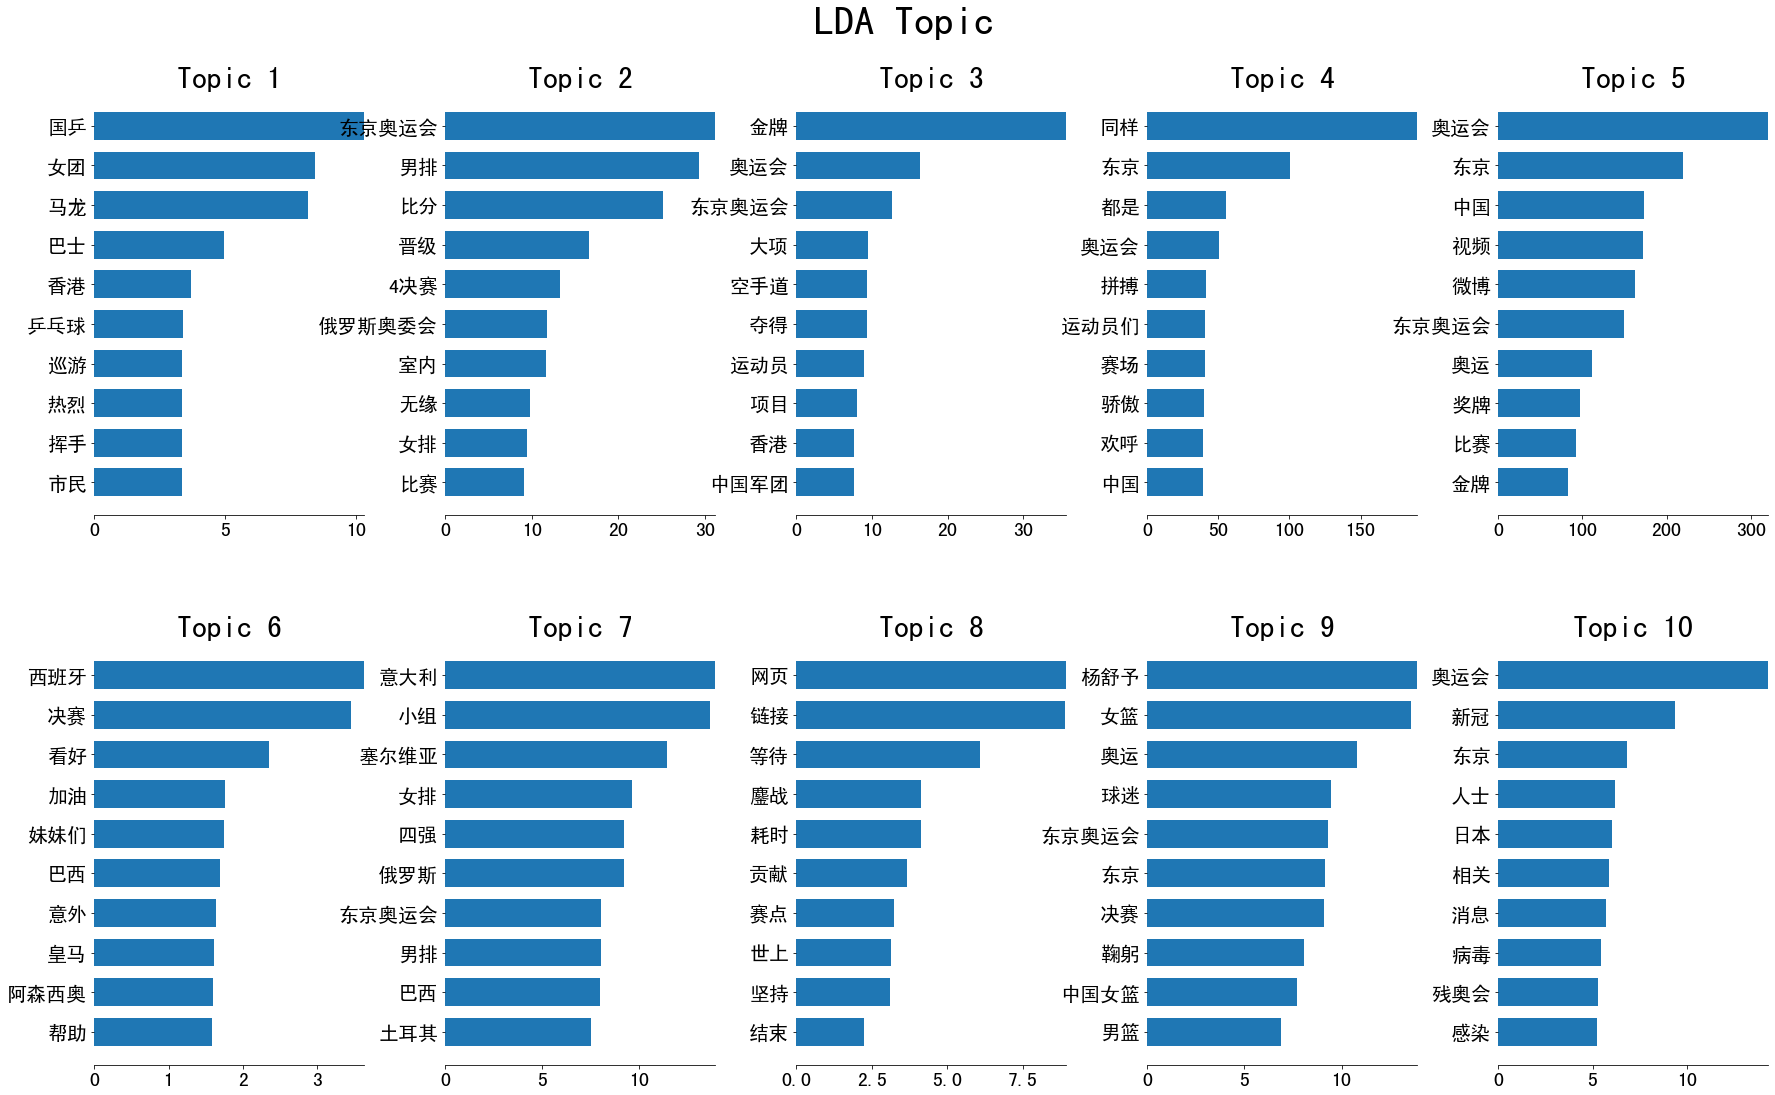

In [47]:
# tdidf方案

# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(
    # max_df=0.95, min_df=2, stop_words=stopWords["stopword"].values.tolist(), token_pattern=r'\b\w+\b')

# tfidf = tfidf_vectorizer.fit_transform(contents.values.astype(str))

lda = LatentDirichletAllocation(
    n_components=10, max_iter=10, learning_method='online', learning_offset=50., random_state=0)

lda.fit(tf)
tf_feature_names = countVectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, 10, 'LDA Topic')


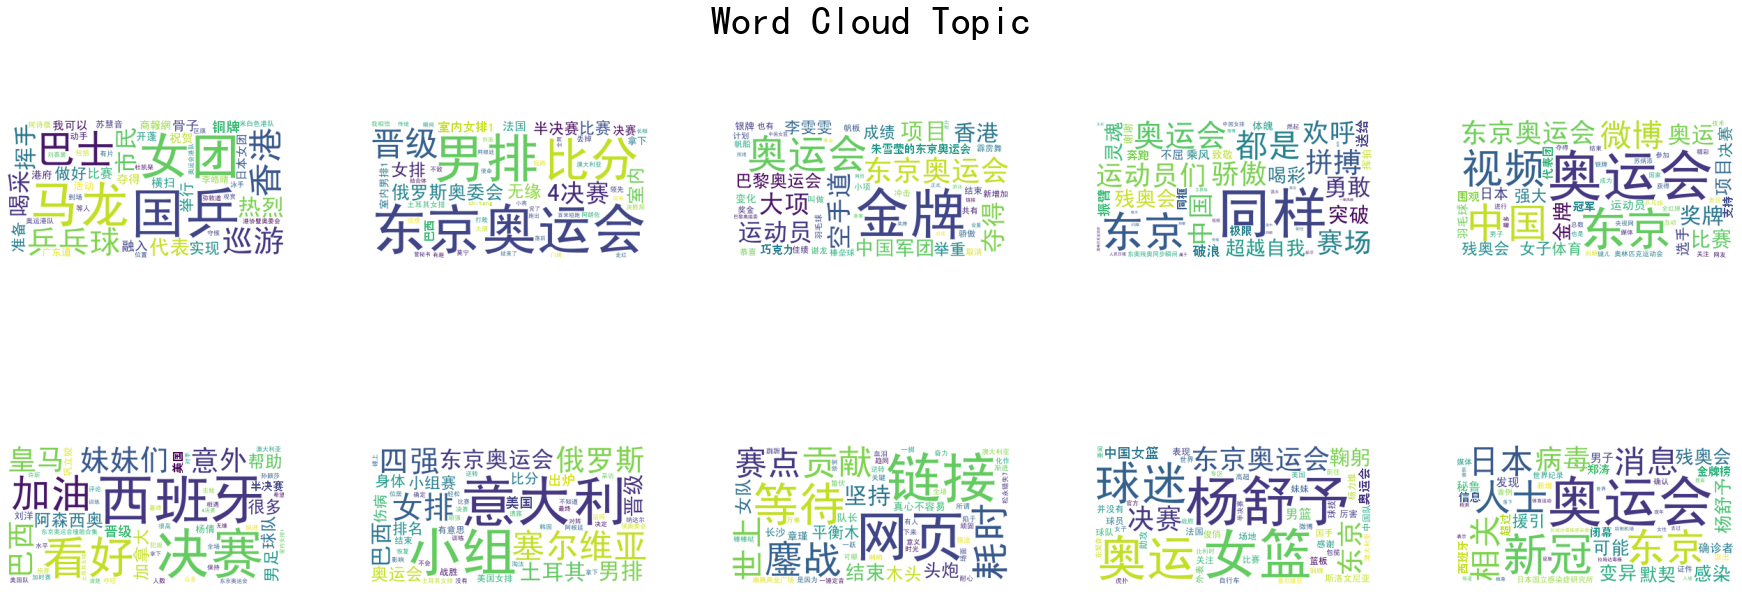

In [78]:
draw_cloud(lda, tf_feature_names, 50, 'Word Cloud Topic')
